In [98]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pydicom import read_file
import copy
import sys
import glob
from copy import deepcopy
from scipy import stats
from matplotlib.gridspec import GridSpec
import tqdm 
import seaborn as sns
%matplotlib inline

PROJ_DIR = "/home/olle/PycharmProjects/LODE"

sys.path.insert(0, os.path.join(PROJ_DIR, 'feature_statistics/utils'))

import statistics_utils as su

plt.style.use('seaborn')

WORK_SPACE = "/home/olle/PycharmProjects/LODE/workspace"

oct_meta_pd = pd.read_csv(os.path.join(WORK_SPACE, "joint_export/export_tables/oct_meta_information.csv"))

oct_meta_pd.loc[:, "sequence"] = oct_meta_pd.PATNR.astype(str) + "_" + oct_meta_pd.laterality

data_pd = pd.read_csv( os.path.join(WORK_SPACE, 
                                    "joint_export/longitudinal_properties_naive_new.csv"))

## filter and preprocess data tables

In [99]:
filter_1, filter_3, filter_12 = su.filter_time_ranges(data_pd)

data_pd = su.preprocess_dataframe(data_pd, oct_meta_pd)

Number of filtered sequences for 3 months are: 507
Number of filtered sequences for 12 months are: 427


## rename lens surgery columns and convert types

In [101]:
data_pd = data_pd.rename(columns={"lens_surgery_1":"cataract_surgery_before_sequence",
                        "lens_surgery_3":"cataract_surgery_3",
                        "lens_surgery_12":"cataract_surgery_12",})

columns_surgery = [
                   "cataract_surgery_before_sequence", 
                   "cataract_surgery_3", 
                   "cataract_surgery_12", 
                  ]


In [102]:
# do type conversion
for c in columns_surgery[1:]:
    data_pd.loc[:, c] = data_pd[c].map({'False':0, 'True': 1}).astype(float).apply(np.ceil).astype(bool)

In [ ]:
## Create data visualizations

In [103]:
data_pd[data_pd.sequence == "68948_L"]["time_range_before_12"]

193   NaN
Name: time_range_before_12, dtype: float64

In [104]:
seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis", 
               "atropypercentage", "thicknessmean"]

seg_delta = []
seg_times = [1, 3, 12]

assert su.assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = su.get_seg_independents_str(seg_features, seg_delta, seg_times)

va_delta = []
va_times = [1, 3, 12]

assert su.assert_times(va_times), "Selected time points contains not allowed values"

va_independents = su.get_va_dependents_str(va_delta, va_times)

injection_times = [3]

assert su.assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_independents.append(f"n_injections_{it}")
    
time_filters = {1: filter_1, 3: filter_3, 12: filter_12}


abt = su.associate_time_n_factors(table=data_pd, spatial_sum=True, time_filters=time_filters, 
                               times=[1, 3, 12])

#abt.loc[:, "thicknessmean_1"] = abt.thicknessmean_1 / 9.
#abt.loc[:, "thicknessmean_3"] = abt.thicknessmean_3 / 9.
#abt.loc[:, "thicknessmean_12"] = abt.thicknessmean_12 / 9.

abt_spatial = su.associate_time_n_factors(table=data_pd, spatial_sum=False, time_filters=time_filters,
                                       times=[1, 3, 12])

seg_indeps = []
for segtime in seg_times:
    seg_indeps.extend(abt.loc[:, ~abt.columns.str.contains("15")].columns.values.tolist())
        
# filter out va columns
# seg_indeps = [i for i in seg_indeps if "va" not in i]
#seg_indeps = [i for i in seg_indeps if "injections" not in i]
seg_indeps = [i for i in seg_indeps if "delta" not in i]


independent_variables = injection_independents + seg_indeps + ["cur_va_rounded_1"]

abt_viz = abt[independent_variables]

# drop duplicate columns
abt_viz = abt_viz.loc[:,~abt_viz.columns.duplicated()]

# add all first order interactions
columns = copy.copy(abt_viz.columns)
            
indep_vars_interactions = list(abt_viz.columns)

abt_viz["va_change"] = abt.cur_va_rounded_12 - abt.cur_va_rounded_1

## join in cataract information

In [106]:
cols_to_merge = ['cataract_surgery_before_sequence', 'cataract_surgery_3', 'cataract_surgery_12', "sequence"]

abt_viz = pd.merge(abt_viz, data_pd[cols_to_merge], left_on="sequence", right_on="sequence", how="left") 

In [107]:
print("number of eyes with cataract before", data_pd.cataract_surgery_before_sequence.sum())

number of eyes with cataract before 199


In [108]:
print("number of eyes with cataract before", data_pd.cataract_surgery_before_sequence.sum())
print("number of eyes with cataract 3", data_pd.cataract_surgery_3.sum())
print("number of eyes with cataract 12", data_pd.cataract_surgery_12.sum())


number of eyes with cataract before 199
number of eyes with cataract 3 125
number of eyes with cataract 12 124


In [109]:

print("number of eyes with cataract before", abt_viz.cataract_surgery_before_sequence.sum())
print("number of eyes with cataract 3", abt_viz.cataract_surgery_3.sum())
print("number of eyes with cataract 12", abt_viz.cataract_surgery_12.sum())


number of eyes with cataract before 101
number of eyes with cataract 3 30
number of eyes with cataract 12 39


# merge in age and gender information

In [110]:
oct_meta_pd_sub = oct_meta_pd[oct_meta_pd.sequence.isin(list(abt_viz.sequence))].drop_duplicates(subset=["sequence"])

In [111]:
oct_meta_pd_sub

,PATNR,laterality,study_date,birthdate,image_type,gender,modality,study_description,img_shape,age,number_of_visits,export,dicom_name,oct_path,AMD,DKEY_first_date,INJECTION,INJECTION_first_date,sequence
1033,187567,R,20180828,19360101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",85,12,1,1.3.6.1.4.1.33437.10.4.6339912.13179925045.176...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-11-23,True,2018-09-13,187567_R
1593,1826,L,20181114,19330101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",88,32,1,1.3.6.1.4.1.33437.10.4.7175529.13186657472.119...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2016-05-31,True,2016-06-02,1826_L
1897,328273,R,20180328,19490101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",72,58,1,1.3.6.1.4.1.33437.10.4.4089432.13166697550.287...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2016-01-14,True,2016-01-14,328273_R
1950,37416,R,20150413,19440101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",77,27,1,1.3.6.1.4.1.33437.10.4.16395944.13073397008.10...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2014-11-18,True,2015-01-09,37416_R
2446,344407,L,20181122,19540101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",67,26,1,1.3.6.1.4.1.33437.10.4.6339912.13187356372.181...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2016-09-27,True,2016-09-27,344407_L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293665,25828,L,20200707,19340201,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",87,16,2,OPt.1.3.6.1.4.1.33437.10.4.16073696.1323858897...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2019-08-02,True,2019-08-02,25828_L
316307,113059,R,20180626,19441101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",76,38,2,OPt.1.3.6.1.4.1.33437.10.4.13118731.1317448532...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-12-05,True,2017-12-06,113059_R
317602,381618,L,20190109,19440701,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",77,38,2,OPt.1.3.6.1.4.1.33437.10.4.16073696.1319149102...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2018-11-30,True,2018-12-03,381618_L
319727,377209,R,20201124,19410601,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",80,20,2,OPt.1.3.6.1.4.1.33437.10.4.9457825.13250688075...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2019-11-05,True,2019-11-05,377209_R


In [112]:
abt_viz = pd.merge(abt_viz, oct_meta_pd_sub[["sequence", "gender", "age"]].drop_duplicates(), 
                   on="sequence", how="left",)

## get base statistics

In [113]:
abt_viz

,sequence,n_injections_3,cur_va_rounded_1,cur_va_rounded_3,cur_va_rounded_12,epm_1,irf_1,srf_1,srhm_1,rpe_1,...,fibrosis_12,atropypercentage_12,thicknessmean_12,n_injections_12,va_change,cataract_surgery_before_sequence,cataract_surgery_3,cataract_surgery_12,gender,age
0,18_R,5.000000,0.4,0.200000,0.30,0.000177,0.002572,0.000079,0.000261,0.198557,...,0.000093,0.0,0.144087,11.0,-0.10,False,False,False,F,86
1,502_L,2.607143,0.3,0.321429,0.40,0.001244,0.000266,0.000154,0.009128,0.201912,...,0.001463,0.0,0.330965,7.0,0.10,False,True,False,F,87
2,709_L,3.000000,0.3,0.600000,0.60,0.046623,0.008564,0.086337,0.022925,0.196917,...,0.049084,0.0,0.150276,8.0,0.30,False,False,False,M,83
3,719_R,3.000000,0.3,0.100000,0.30,0.007120,0.000112,0.000047,0.000457,0.193674,...,0.000037,0.0,0.134880,3.0,0.00,False,False,False,F,81
4,735_R,3.000000,0.9,0.890000,0.89,0.006081,0.537244,0.080452,0.000005,0.205854,...,0.000000,0.0,0.175734,6.0,-0.01,False,False,False,M,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,383154_L,3.000000,1.0,0.400000,NaN,0.005792,0.200826,0.001514,0.010969,0.212489,...,0.011313,0.0,0.237686,9.0,NaN,True,False,False,F,82
345,383182_L,4.482143,1.2,1.000000,1.00,0.075713,0.010936,0.000126,0.007367,0.160721,...,0.004967,0.0,0.122623,8.0,-0.20,True,True,False,F,84
346,383332_L,5.000000,1.1,1.600000,NaN,0.001524,0.001011,0.005582,0.008872,0.192150,...,0.000065,0.0,0.141115,11.0,NaN,True,False,False,F,87
347,383602_L,3.000000,1.1,1.300000,1.70,0.002306,0.014398,0.116022,0.213905,0.118725,...,0.117896,0.0,0.131557,8.0,0.60,False,False,False,F,77


In [114]:
print("Mean age: ", np.mean(abt_viz.age), np.std(abt_viz.age))
print("sex distribution: ", np.unique(abt_viz.gender, return_counts=1))
print("injection month 3: ", np.mean(abt_viz.n_injections_3), np.std(abt_viz.n_injections_3))
print("injections month 12: ", np.mean(abt_viz.n_injections_12), np.std(abt_viz.n_injections_12))


Mean age:  81.43553008595988 7.698807154085606
sex distribution:  (array(['F', 'M'], dtype=object), array([211, 138]))
injection month 3:  3.7448868611921062 1.5100603326580122
injections month 12:  8.532126422300161 3.3421266979505275


In [115]:
def get_time_dict(feature, time_point, data_pd, feature_change, time_filters, spatial_sum=True):
    data_temp = su.associate_time_n_factors(table=data_pd, spatial_sum=spatial_sum, time_filters=time_filters,
                                         times=[1, time_point])
    
    # calc feature delta
    feature_delta = data_temp[f"{feature}_{time_point}"] - data_temp[f"{feature}_{1}"]
    
    # get data points for feature increase or decrease cases
    if feature_change == "increase":
        data_temp = data_temp[feature_delta >= 0]
    else:
        data_temp = data_temp[feature_delta < 0]
        
    feature_columns = data_temp[[f"{feature}_{time_point}"]]
    feature_columns.loc[:, "va_change"] = data_temp[f"cur_va_rounded_{time_point}"] - data_temp["cur_va_rounded_1"]

    feature_columns["va_class"] = None
    feature_columns["va_class"][feature_columns.va_change > 0.15] = 0
    feature_columns["va_class"][(feature_columns.va_change > -0.15) & (feature_columns.va_change <= 0.15)] = 1
    feature_columns["va_class"][feature_columns.va_change <= -0.15] = 2
    
    n_injections = np.round(data_temp[f"n_injections_{time_point}"].mean(),2)
    
    dict_ = dict(feature_columns.va_class.value_counts())
    dict_[f"injections"] = n_injections
    return dict_

def plot_stacked_bar(viz_dict, time, x_pos):
    
    lost = np.array([viz_dict[time][0]])
    no_change = np.array([viz_dict[time][1]])
    gained = np.array([viz_dict[time][2]])

    # memo of sample number
    snum = lost+no_change+gained

    # normalization
    y1 = lost/snum*100.
    y2 = no_change/snum*100.
    y3 = gained/snum*100.
    
    width = 0.2
    
    # stack bars
    plt.bar(x_pos, y1, color="tab:red", width=width)
    plt.bar(x_pos, y2 , bottom=y1, color="tab:blue", width=width)
    plt.bar(x_pos, y3 , bottom=y1+y2, color="tab:green", width=width)

    # add text annotation corresponding to the percentage of each data.
    for xpos, ypos, yval in zip([x_pos], y1/2, y1):
        plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
    for xpos, ypos, yval in zip([x_pos], y1+y2/2, y2):
        plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
    for xpos, ypos, yval in zip([x_pos], y1+y2+y3/2, y3):
        plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
    
    # add text annotation corresponding to the "total" value of each bar
    for xpos, ypos, yval in zip([x_pos], y1+y2+y3, snum):
        plt.text(xpos, ypos, "N=%d"%yval, ha="center", va="bottom")
        plt.text(xpos, ypos + 4, "mean_inj=%d"%viz_dict[time]["injections"], ha="center", va="bottom")

    plt.ylim(0,110)

## Plot 1 Feature distribution

In [116]:
## add special features
abt_viz = pd.merge(abt_viz, abt_spatial[["C0-choroid_1", 
                                         "C0-choroid_3", 
                                         "C0-choroid_12"]], on="sequence")

cataract_f = abt_viz[~abt_viz.cataract_surgery_12.fillna(0).astype(bool)]

In [117]:
feature_list = ["thicknessmean", "C0-choroid", "irf", "rpe", "srf", "srhm", "fvpde", "fibrosis", "drusen"]

time_feature_list = []
time_points = [1, 3, 12]
for time in time_points:
    for feature in feature_list:
        time_feature_list.append(f"{feature}_{time}")
        
plot1_ = [i for i in cataract_f.columns.tolist() if i in time_feature_list]

plot1_abt = cataract_f[plot1_ + ["cataract_surgery_before_sequence"]]

plot1_abt.loc[:, "cataract_surgery_before_sequence"] = plot1_abt.cataract_surgery_before_sequence.fillna(0.0)

In [75]:
plot1_abt = abt_viz

In [118]:
## check examples
feature = "thicknessmean"
sequence = "15425_R"
seq_pd = cataract_f[cataract_f.sequence == sequence]
feature_cols = ["sequence"] + [col for col in seq_pd.columns.tolist() if feature in col]

seq_pd[feature_cols]

,sequence,thicknessmean_1,thicknessmean_3,thicknessmean_12
24,15425_R,0.199164,0.231573,0.296391


In [119]:
color_mapping = {"bg": ("background", [148., 158., 167.]),
                 "epm": ("epiretinal membrane", [11., 151., 199.]),
                 "nsr":("neurosensory retina", [30., 122., 57.]),
                 "irf": ("intra retinal fluid", [135., 191., 234.]),
                 "srf":("sub retinal fluid", [37., 111., 182.]),
                 "srhm": ("sub retinal hyp. material", [156., 99., 84.]),
                 "rpe": ("RPE", [226., 148., 60.]),
                 "fvpde": ("fibrovascular PED", [203., 54., 68.]),
                 "drusen": ("drusen", [192., 194., 149.]),
                 "phm":("post. hylaoid membrane", [105., 194., 185.]),
                 "choroid": ("choroid", [205., 205., 205.]),
                 "serous_ped": ("serous PED", [140., 204., 177.]),  # Serous PED
                 "other_artifact": ("other artifact", [183., 186., 219.]),  # other artifact
                 "fibrosis":("fibrosis", [114, 137, 218]),  # fibrosis
                 "vitreous": ("vitreous", [209., 227., 239.]),
                 "camera_effect": ("camera effect", [226., 233., 48.])}


# normalite colors
color_mapping_norm = {}
for key in color_mapping.keys():
    color = color_mapping[key][1]
    color_norm = [c / 255. for c in color]
    color_mapping_norm[key] = (color_mapping[key][0], color_norm)
    

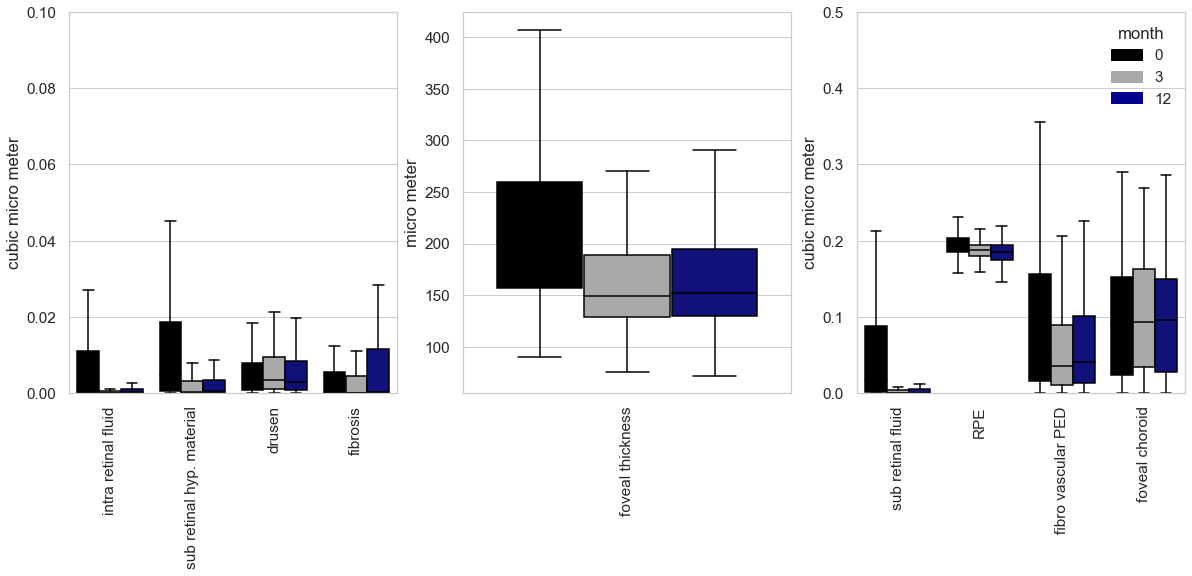

In [143]:
sns.set(font_scale=1.4)
sns.set_style("whitegrid")

plot1_abt_long = plot1_abt.melt(id_vars=["cataract_surgery_before_sequence"])

plot1_abt_long.loc[:, "time"] = plot1_abt_long.variable.str.split("_", expand=True)[1]
plot1_abt_long.loc[:, "feature"] = plot1_abt_long.variable.str.split("_", expand=True)[0]

small_ = plot1_abt_long.feature.isin(["irf", "srhm", "drusen", "fibrosis"])
large_ = plot1_abt_long.feature.isin(["fvpde", "rpe", "C0-choroid", "srf"])
thickness_ = plot1_abt_long.feature.isin(["thicknessmean"])

cataract_surgery = plot1_abt_long.cataract_surgery_before_sequence == 1.0

plot1_abt_long = plot1_abt_long.rename(columns={"value":"cubic mm"})

# convert thickness measurements to micro meter
plot1_abt_long[thickness_]["cubic mm"] = plot1_abt_long[thickness_]["cubic mm"] * 1000.

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

table_small = plot1_abt_long[small_]
g0 = sns.boxplot(x="feature", y="cubic mm", hue="time",
            data=table_small, 
            showfliers=False, ax=axes[0],
            palette=["black", "darkgrey", "darkblue"]);

g0.set(xticks=[0,1,2,3])
g0.set_xticklabels(['intra retinal fluid','sub retinal hyp. material',
                    'drusen','fibrosis'], rotation=90)

axes[0].set_ylabel("cubic micro meter")

thickness_pd = plot1_abt_long[thickness_].copy()

thickness_pd["cubic mm"] = thickness_pd["cubic mm"] * 1000

g1 = sns.boxplot(x="feature", y="cubic mm", hue="time",
            data=thickness_pd, 
            showfliers=False, ax=axes[1],
            palette=["black", "darkgrey", "darkblue"]);


axes[1].set_ylabel("micro meter")

g1.set(xticks=[0])
g1.set_xticklabels(['foveal thickness'], rotation=90)

g2 = sns.boxplot(x="feature", y="cubic mm",
            hue="time",
            data=plot1_abt_long[large_], 
            showfliers=False, ax=axes[2],
            palette=["black", "darkgrey", "darkblue"]);


g2.set(xticks=[0,1,2, 3])
g2.set_xticklabels(['sub retinal fluid', 'RPE','fibro vascular PED','foveal choroid'], rotation=90)

g0.legend([])
g1.legend([])
g2.legend([])

g0.set_ylim(0, 0.1)
g2.set_ylim(0, 0.5)

axes[2].set_ylabel("cubic micro meter")

axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

import matplotlib.patches as mpatches

black_patch = mpatches.Patch(color='black', label='0')
grey_patch = mpatches.Patch(color='darkgrey', label='3')
darkblue_patch = mpatches.Patch(color='darkblue', label='12')

plt.legend(title="month", handles=[black_patch, grey_patch, darkblue_patch])

#plt.suptitle("OCT bio marker change under antiVEGF treatment")

## simple statistics for paper

In [171]:
## Number of eyes recieving Anti-VEGF

cumsum_injections = abt_viz.n_injections_3 + abt_viz.n_injections_12

print("number of patients recieving anti-VEGF", np.sum(cumsum_injections > 0))

# treatment start & end dates
min_ = data_pd[filter_1 & filter_3 & filter_12].study_date_1.min()
max_ = data_pd[filter_1 & filter_3 & filter_12].study_date_12.max()

print("first treatment was: ", min_, "last treatment was: ", max_)

number of patients recieving anti-VEGF 349
first treatment was:  2013-01-04 last treatment was:  2021-01-15


## print statistics data

In [172]:
plot1_abt.loc[:, "thicknessmean_1"] = plot1_abt.loc[:, "thicknessmean_1"] * 1000
plot1_abt.loc[:, "thicknessmean_3"] = plot1_abt.loc[:, "thicknessmean_3"] * 1000
plot1_abt.loc[:, "thicknessmean_12"] = plot1_abt.loc[:, "thicknessmean_12"] * 1000

In [173]:
seg_features = [
                "epm", 
                "irf", 
                "srf", 
                "srhm", 
                "rpe", 
                "fvpde", 
                "drusen", 
                "phm", 
                "choroid", 
                "fibrosis", 
#                "atropypercentage", 
                "thicknessmean"
               ]

seg_times = [1, 3, 12]

stats_log = {}

for feature in seg_features:
    stats_log[feature] = {}
    for time in seg_times:
        if feature == "thicknessmean":
            stats_log[feature][f"mean_{time}"] = abt_viz.loc[:, f"{feature}_{time}"].mean()
            stats_log[feature][f"std_{time}"] = abt_viz.loc[:, f"{feature}_{time}"].std()
        else:
            stats_log[feature][f"mean_{time}"] = abt_viz.loc[:, f"{feature}_{time}"].mean()
            stats_log[feature][f"std_{time}"] = abt_viz.loc[:, f"{feature}_{time}"].std()

## test for stat significance

In [174]:
from scipy import stats

for feature in seg_features:
    
    stats_log[feature] = {}
    rvs1 = abt_viz.loc[:, f"{feature}_{1}"]
    rvs3 = abt_viz.loc[:, f"{feature}_{3}"]
    rvs12 = abt_viz.loc[:, f"{feature}_{12}"]
    
    if feature == "thicknessmean":
        print()
        rvs1 = abt_viz.loc[:, f"{feature}_{1}"] * 1000
        rvs3 = abt_viz.loc[:, f"{feature}_{3}"] * 1000
        rvs12 = abt_viz.loc[:, f"{feature}_{12}"] * 1000

    stats_log[feature]["mean 1"] = np.nanmean(rvs1)
    stats_log[feature]["mean 3"] = np.nanmean(rvs3)
    stats_log[feature]["mean 12"] = np.nanmean(rvs12)
    
    stats_log[feature]["standard deviation 1"] = np.nanstd(rvs1)
    stats_log[feature]["standard deviation 3"] = np.nanstd(rvs3)
    stats_log[feature]["standard deviation 12"] = np.nanstd(rvs12)
    
    stats_log[feature]["p-value (1-3)"] = stats.ttest_ind(rvs1, rvs3).pvalue
    stats_log[feature]["p-value (1-12)"] = stats.ttest_ind(rvs1, rvs12).pvalue
    stats_log[feature]["p-value (3-12)"] = stats.ttest_ind(rvs3, rvs12).pvalue


stat_log_pd = pd.DataFrame(stats_log)

In [175]:
stat_log_pd.round(2)

,epm,irf,srf,srhm,rpe,fvpde,drusen,phm,choroid,fibrosis,thicknessmean
mean 1,0.01,0.03,0.08,0.02,0.19,0.12,0.01,0.0,0.93,0.02,225.78
mean 3,0.01,0.01,0.01,0.01,0.18,0.09,0.01,0.0,0.96,0.02,169.40
mean 12,0.01,0.01,0.01,0.00,0.18,0.10,0.01,0.0,0.95,0.03,172.06
standard deviation 1,0.02,0.08,0.26,0.05,0.02,0.19,0.01,0.0,0.41,0.06,90.36
standard deviation 3,0.02,0.07,0.09,0.02,0.02,0.16,0.01,0.0,0.42,0.06,64.50
standard deviation 12,0.02,0.04,0.04,0.01,0.02,0.16,0.01,0.0,0.41,0.08,62.30
p-value (1-3),0.60,0.00,0.00,0.00,0.00,0.02,0.46,NaN,0.41,0.57,0.00
p-value (1-12),0.36,0.00,0.00,0.00,0.00,0.05,0.79,NaN,0.49,0.25,0.00
p-value (3-12),0.70,0.78,0.86,0.26,0.01,0.62,0.29,NaN,0.89,0.09,0.58


## test for significance for VA

In [179]:
# check number of records with no missing va values

abt_viz_no_va_missing = abt_viz.dropna(how="any", 
                                       subset=["cur_va_rounded_1", 
                                               "cur_va_rounded_3", 
                                               "cur_va_rounded_12"])

In [182]:
abt_viz_no_va_missing.shape

(292, 51)

In [180]:
va_stats_logs = {}

feature = "cur_va_rounded"
abt_viz_no_va_missing.cur_va_rounded_1.mean()

rvs1 = abt_viz_no_va_missing.loc[:, f"{feature}_{1}"]
rvs3 = abt_viz_no_va_missing.loc[:, f"{feature}_{3}"]
rvs12 = abt_viz_no_va_missing.loc[:, f"{feature}_{12}"]

va_stats_logs["mean_1"] = rvs1.mean()
va_stats_logs["mean_3"] = rvs3.mean()
va_stats_logs["mean_12"] = rvs12.mean()

va_stats_logs["std_1"] = rvs1.std()
va_stats_logs["std_3"] = rvs3.std()
va_stats_logs["std_12"] = rvs12.std()

va_stats_logs["ptest_1-3"] = stats.ttest_ind(rvs1, rvs3).pvalue
va_stats_logs["ptest_1-12"] = stats.ttest_ind(rvs1, rvs12).pvalue
va_stats_logs["ptest_3-12"] = stats.ttest_ind(rvs3, rvs12).pvalue



# abt_viz

In [181]:
pd.DataFrame(va_stats_logs, index=[0]).T

,0
mean_1,0.594110
mean_3,0.496717
mean_12,0.514471
std_1,0.445172
std_3,0.357975
std_12,0.369357
ptest_1-3,0.003713
ptest_1-12,0.018974
ptest_3-12,0.555545


In [87]:
data_filtered = data_pd[filter_1 & filter_3 & filter_12]

dicoms = data_filtered[["study_date_1_dicom_path", "study_date_3_dicom_path", "study_date_12_dicom_path"]]

dicom_paths = pd.melt(dicoms)["value"].tolist()